#  Explore SDSSRM-XCS Scatter: Targeted or Serendipitous?

This section of the project explores potential reasons and diagnostics of galaxy cluster/group scaling relation scatter using the new SDSSRM-XCS relations constructed in this work from the properties measured in the first paper of this series [(Turner et al. 2024)](https://ui.adsabs.harvard.edu/abs/2025MNRAS.tmp...10T/abstract).

Here we use several relations to investigate whether there are obvious correlations between the scatter-from-expected-values of individual data points and whether the galaxy cluster/group that they represent had a targeted XMM observation or if the data were serendipitous. Separating clusters into targeted and serendipitous was an approach taken for the SDSSRM-XCS sample by [Giles et al. (2022)](https://ui.adsabs.harvard.edu/abs/2022MNRAS.516.3878G/abstract) when examining $L_{\rm{X}}$-$T_{\rm{X}}$ relations. They found that distinctly different relations when treating the two 'classes' independently. 

Scaling relation fits were performed using the XGA interface to the R scaling-relation fitting package LIRA, see the paper for full details.

## Main takeaways

In summary:
* In the original SDSSRM-XCS sample of 150 clusters, ~35% were classed as being serendipitious so far as XMM observations were concerned.
* The SDSSRM-XCS $M_{500}$-$T_{\rm{X,500}}$ relation uses 104 of the original sample, all those that for which we could measure a hydrostatic mass in the first paper of this series - of those clusters, ~22% are classed as being serendipitous. Given the data quality requirements for hydrostatic masses, and the fact that serendipitous observations are typically lower quality, this drop in sample fraction isn't surprising.
* When the $M_{500}$-$T_{\rm{X,500}}$ relation is plotted with data points coloured by whether they were targeted or serendipitous, it seems likely that serendipitous data points are contributing quite a bit to the intrinsic scatter. Most are low mass systems (possibly approaching group scale) which are more significantly effected by feedback processes than more massive systems. Another possible cause is that lower mass clusters/groups are less X-ray bright than massive clusters, which has likely led to lower data quality.
* The targeted/serendipitous classification **does not** draw a neat boundary in the $M_{500}$-$T_{\rm{X,500}}$ relation between very scattered points and those which are closer to the expected values.
* This holds true for the $M_{2500}$-$T_{\rm{X,2500}}$ relation as well.
* We also examined the $M^{\rm{gas}}_{500}$-$L^{\rm{bol}}_{\rm{X,500ce}}$ and $M^{\rm{gas}}_{2500}$-$L^{\rm{bol}}_{\rm{X,2500}}$ relations, with the same data point colouring - once again there is no neat boundary, and indeed in this case the serendipitous points don't visually appear to be any more responsible for scatter in the relation than targeted points.
* Finally, we performed the same inspection _again_ for the $M^{\rm{tot}}_{500}$-$\lambda_{\rm{RM}}$ relation. This mass-observable relation has a large intrinsic scatter, with targeted and serendipitous points alike scattered far away from the expected value. Interestingly though, the serendipitous data points are mostly scattered _below_ the line. 

## Import Statements

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 500)
import numpy as np
from astropy.units import Quantity
from astropy.cosmology import LambdaCDM
import pickle
import matplotlib
from matplotlib.colors import LinearSegmentedColormap

# This adds the directory above to the path, allowing me to import the common functions that I've written in
#  common.py - this just saves me repeating boring code and makes sure its all consistent
import sys
sys.path.insert(0, '..')
from common import xcs_cosmo

import xga

## Setting up data point colours for 'targeted' and 'serendipitous'

One of the things we will do in this notebook is to colour the data points in several of our new scaling relations based on whether they were considered by [Giles et al. (2022)](https://ui.adsabs.harvard.edu/abs/2022MNRAS.516.3878G/abstract) to be targeted by XMM, or to have serendipitous observations. 

Here we set up a two-segment matplotlib colour-map, which will define the colours given to the data points:

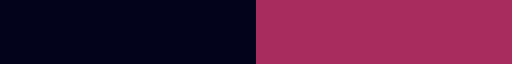

In [2]:
donor_cmap = matplotlib.colormaps['inferno']
binary_cmap = LinearSegmentedColormap.from_list('binary', donor_cmap([0.05, 0.45]), N=2)
binary_cmap

## Loading data files and relations

We load the 'base' SDSSRM-XCS sample file, as it contains information on whether each cluster was classified as 'targeted' or 'serendipitious' in the original work that assembled the SDSSRM-XCS sample. 

The new SDSSRM-XCS scaling relations (constructed in the course of this work) which we will explore the scatter for in this notebook are also loaded in here - note that we do not load every single relation, but rather make a representative selection. Please see the individual notebooks in the 'new_sdssrm_relations' directory for full details of the relations.

### SDSSRM-XCS base sample

In [3]:
sdssxcs_base = pd.read_csv("../../sample_files/SDSSRM-XCS_base_sample.csv")
sdssxcs_base.head(6)

,name,MEM_MATCH_ID,xapa_ra,xapa_dec,rm_ra,rm_dec,z,r500,r500-,r500+,richness,richness_err,XCS_NAME,R_LAMBDA,xmm_targeted,xmm_serendipitous
0,SDSSXCS-124,124,0.80058,-6.09182,0.798261,-6.091694,0.2475,1181.028,21.202,23.203,109.550,4.490,XMMXCS J000312.1-060530.5,1.018410,True,False
1,SDSSXCS-2789,2789,0.95554,2.06802,0.956981,2.066469,0.1053,1007.861,17.194,17.202,38.904,2.830,XMMXCS J000349.3+020404.8,0.827942,True,False
2,SDSSXCS-290,290,2.72264,29.16102,2.714137,29.161154,0.3485,913.052,30.879,31.210,105.096,5.994,XMMXCS J001053.4+290939.6,1.009990,True,False
3,SDSSXCS-1018,1018,4.40633,-0.87619,4.406711,-0.878340,0.2144,902.259,22.445,23.366,56.997,3.219,XMMXCS J001737.5-005234.2,0.893655,False,True
4,SDSSXCS-134,134,4.90839,3.60982,4.911069,3.599257,0.2773,1123.321,19.219,19.226,108.604,4.792,XMMXCS J001938.0+033635.3,1.016645,True,False
5,SDSSXCS-119,119,8.46470,-7.86290,8.471426,-7.869543,0.3042,944.275,46.422,46.747,128.192,5.697,XMMXCS J003351.5-075146.4,1.050926,True,False


### $M^{\rm{tot}}_{500}$-$T_{\rm{X,500}}$

In [4]:
with open('../../outputs/scaling_relations/sdssrm-xcs_new/mtot-tx/turner2025_mtot500_tx500.xgarel', 'rb') as scalo:
    mtot500_tx500 = pickle.load(scalo)

### $M^{\rm{tot}}_{2500}$-$T_{\rm{X,2500}}$

In [5]:
with open('../../outputs/scaling_relations/sdssrm-xcs_new/mtot-tx/turner2025_mtot2500_tx2500.xgarel', 'rb') as scalo:
    mtot2500_tx2500 = pickle.load(scalo)

### $M^{\rm{gas}}_{500}$-$L^{\rm{bol}}_{\rm{X,500ce}}$

In [6]:
with open('../../outputs/scaling_relations/sdssrm-xcs_new/mgas-lx/turner2025_mgas500_lxbol_500ce.xgarel', 'rb') as scalo:
    mgas500_lxbol_500ce = pickle.load(scalo)

### $M^{\rm{gas}}_{2500}$-$L^{\rm{bol}}_{\rm{X,2500}}$

In [13]:
with open('../../outputs/scaling_relations/sdssrm-xcs_new/mgas-lx/turner2025_mgas2500_lxbol_2500.xgarel', 'rb') as scalo:
    mgas2500_lxbol_2500 = pickle.load(scalo)

### $M^{\rm{tot}}_{500}$-$\lambda_{\rm{RM}}$

In [17]:
with open('../../outputs/scaling_relations/sdssrm-xcs_new/mtot-richness/turner2025_mtot500_richness.xgarel', 'rb') as scalo:
    mtot500_rich = pickle.load(scalo)

## Distinguishing targeted/serendipitious clusters in relations

### $M^{\rm{tot}}_{500}$-$T_{\rm{X,500}}$ 

In [21]:
# As the relation is not guaranteed to contain all the data points in the same file, nor to necessarily be in the same order, we 
#  use this search-sorted trick to get the indices in the base sample that correspond to the names given to each datapoint when 
#  the scaling relation was constructed
sort_rel_names = np.argsort(sdssxcs_base['name'].values)
pnt_samp_ind = sort_rel_names[np.searchsorted(sdssxcs_base['name'].values, mtot500_tx500.point_names, sorter=sort_rel_names)]

# Reads out whether the clusters were considered XMM targeted by Giles et al. (2022), in the right order!
xmm_targ = sdssxcs_base.loc[pnt_samp_ind, 'xmm_targeted'].values
# Don't recommend setting attributes directly, but apparently I never added property setters for these when I 
#  wrote this class
mtot500_tx500._third_dim_info = xmm_targ
mtot500_tx500._third_dim_name = "XMM Targeted"

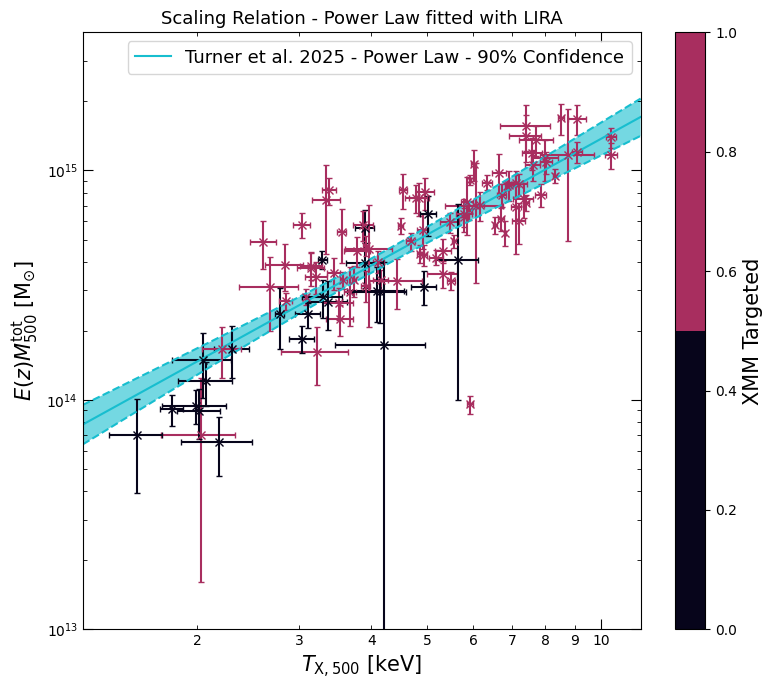

In [8]:
mtot500_tx500.view(figsize=(8, 7), y_lims=Quantity([1e+13, 4e+15], 'Msun'), third_dim_cmap=binary_cmap)

### $M^{\rm{tot}}_{2500}$-$T_{\rm{X,2500}}$

In [9]:
# Same procedure as above, to ensure that the targeted/serendipitious flags are applied to the correct data points
sort_rel_names = np.argsort(sdssxcs_base['name'].values)
pnt_samp_ind = sort_rel_names[np.searchsorted(sdssxcs_base['name'].values, mtot2500_tx2500.point_names, sorter=sort_rel_names)]
xmm_targ = sdssxcs_base.loc[pnt_samp_ind, 'xmm_targeted'].values
mtot2500_tx2500._third_dim_info = xmm_targ
mtot2500_tx2500._third_dim_name = "XMM Targeted"

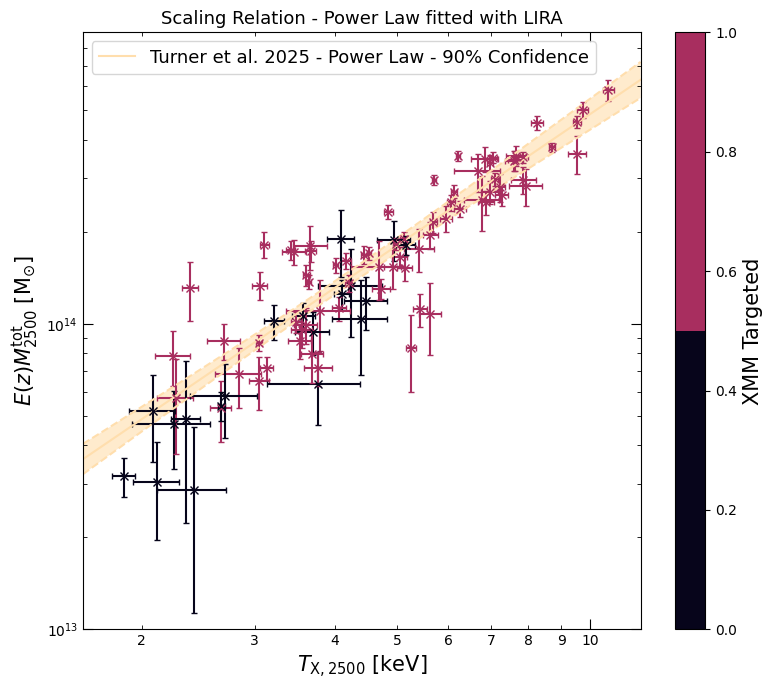

In [10]:
mtot2500_tx2500.view(figsize=(8, 7), y_lims=Quantity([1e+13, 9e+14], 'Msun'), third_dim_cmap=binary_cmap)

### $M^{\rm{gas}}_{500}$-$L^{\rm{bol}}_{\rm{X,500ce}}$

In [11]:
# Same procedure as above, to ensure that the targeted/serendipitious flags are applied to the correct data points
sort_rel_names = np.argsort(sdssxcs_base['name'].values)
pnt_samp_ind = sort_rel_names[np.searchsorted(sdssxcs_base['name'].values, mgas500_lxbol_500ce.point_names, sorter=sort_rel_names)]
xmm_targ = sdssxcs_base.loc[pnt_samp_ind, 'xmm_targeted'].values
mgas500_lxbol_500ce._third_dim_info = xmm_targ
mgas500_lxbol_500ce._third_dim_name = "XMM Targeted"

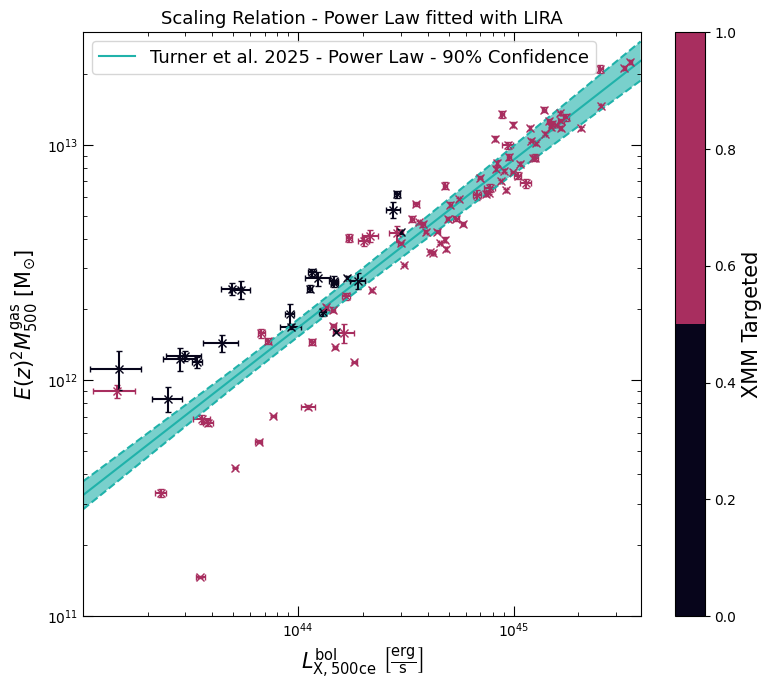

In [12]:
mgas500_lxbol_500ce.view(figsize=(8, 7), y_lims=Quantity([1e+11, 3e+13], 'Msun'), third_dim_cmap=binary_cmap)

### $M^{\rm{gas}}_{2500}$-$L^{\rm{bol}}_{\rm{X,2500}}$

In [15]:
# Same procedure as above, to ensure that the targeted/serendipitious flags are applied to the correct data points
sort_rel_names = np.argsort(sdssxcs_base['name'].values)
pnt_samp_ind = sort_rel_names[np.searchsorted(sdssxcs_base['name'].values, mgas2500_lxbol_2500.point_names, sorter=sort_rel_names)]
xmm_targ = sdssxcs_base.loc[pnt_samp_ind, 'xmm_targeted'].values
mgas2500_lxbol_2500._third_dim_info = xmm_targ
mgas2500_lxbol_2500._third_dim_name = "XMM Targeted"

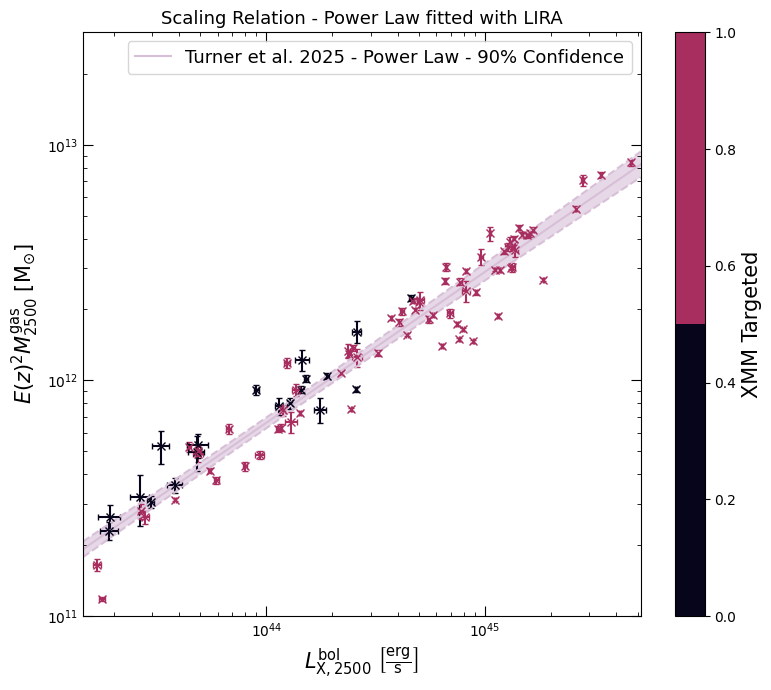

In [16]:
mgas2500_lxbol_2500.view(figsize=(8, 7), y_lims=Quantity([1e+11, 3e+13], 'Msun'), third_dim_cmap=binary_cmap)

### $M^{\rm{tot}}_{500}$-$\lambda_{\rm{RM}}$

In [18]:
# Same procedure as above, to ensure that the targeted/serendipitious flags are applied to the correct data points
sort_rel_names = np.argsort(sdssxcs_base['name'].values)
pnt_samp_ind = sort_rel_names[np.searchsorted(sdssxcs_base['name'].values, mtot500_rich.point_names, sorter=sort_rel_names)]
xmm_targ = sdssxcs_base.loc[pnt_samp_ind, 'xmm_targeted'].values
mtot500_rich._third_dim_info = xmm_targ
mtot500_rich._third_dim_name = "XMM Targeted"

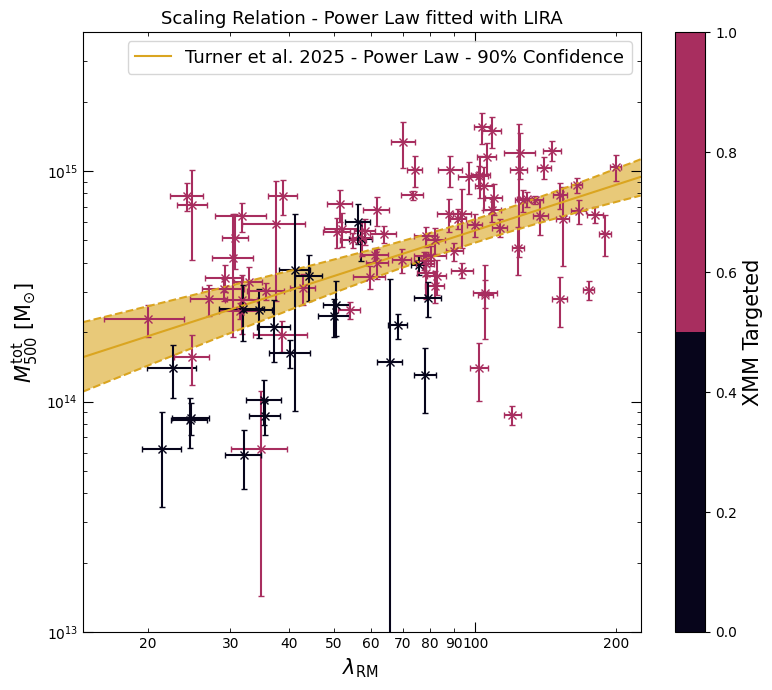

In [19]:
mtot500_rich.view(figsize=(8, 7), y_lims=Quantity([1e+13, 4e+15], 'Msun'), third_dim_cmap=binary_cmap)